## [1주차] 심화과제 - MNIST 예측 모델에 deep learning techniques 적용하기

과제 목표: 기존 mnist-classification-basic 에서 구현한 코드를 기반으로, 필요한 부분을 수정하거나 기능을 추가합니다.

### 1. 필요한 라이브러리 import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### 2. CIFAR10 Dataset 로딩
- Dataset을 MNIST에서 CIFAR10으로 변경해줍니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100.0%


### 3. 데이터 확인
- CIFAR10은 MNIST와 다른 입력 shape을 가지고 있습니다.
- 입력 shape은 model을 선언할 때 중요하기 때문에 MNIST 실습 자료에서 사용한 방식과 똑같이 shape을 확인합니다.

50000
torch.Size([3, 32, 32]) 6


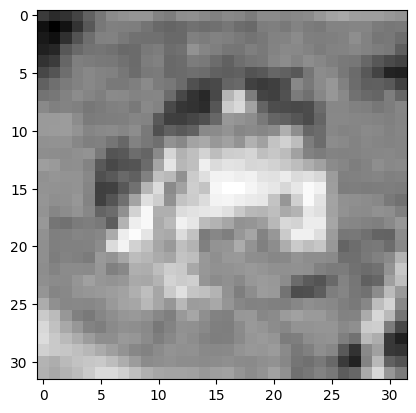

In [3]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

### 4. DataLoader 생성

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

### 5. 첫 번째 batch 확인

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


### 6. MLP 모델 정의
- Activation 함수를 nn.ReLU에서 nn.LeakyReLU로 변경합니다.
- CIFAR10은 (3, 32, 32) size 이므로, **Model(3 * 32 * 32, 1024)로 생성**합니다.
- LeakyReLU를 사용한 기본 Model을 정의합니다.

In [6]:
from torch import nn


class Model(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        return x


model = Model(3 * 32 * 32, 1024)

### 7. 정확도 측정 함수 정의

In [7]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()
    model.train()
    return acc / cnt

### 8. 모델 학습
- 학습 인자는 n_epochs = 50 으로 설정합니다.
- 여러 모델을 학습시키기 위해서 모델 학습 함수를 따로 정의합니다.
    - Model: LeakyReLU() 사용한 기본 Model
    - Model_Sigmoid: Sigmoid() 사용한 기본 Model

In [8]:
def train(model, optimizer):
    n_epochs = 50
    model = model.to('cuda')
    train_accs = []

    for epoch in range(n_epochs):
        total_loss = 0.

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            preds = model(inputs)
            loss = nn.CrossEntropyLoss()(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_acc = accuracy(model, trainloader)
        train_accs.append(train_acc)

        print(f"Epoch {epoch:3d} | Loss: {total_loss}")

    return train_accs

### 9. 정확도 시각화
- 정확도 시각화를 위한 함수를 정의합니다.

In [9]:
def plot_acc(acc_lists, labels, title):
    for acc, label in zip(acc_lists, labels):
        x = np.arange(len(acc))
        plt.plot(x, acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    plt.show()

### 10. Plot 1 - SGD vs Adam

Epoch   0 | Loss: 449.7118396759033
Epoch   1 | Loss: 447.6072657108307
Epoch   2 | Loss: 445.68342995643616
Epoch   3 | Loss: 443.7384629249573
Epoch   4 | Loss: 441.6965036392212
Epoch   5 | Loss: 439.511878490448
Epoch   6 | Loss: 437.13055539131165
Epoch   7 | Loss: 434.58496022224426
Epoch   8 | Loss: 431.89638805389404
Epoch   9 | Loss: 429.0262396335602
Epoch  10 | Loss: 426.03916335105896
Epoch  11 | Loss: 422.975625038147
Epoch  12 | Loss: 419.89524960517883
Epoch  13 | Loss: 416.9048504829407
Epoch  14 | Loss: 414.084734916687
Epoch  15 | Loss: 411.35818433761597
Epoch  16 | Loss: 408.83638405799866
Epoch  17 | Loss: 406.47101759910583
Epoch  18 | Loss: 404.25576090812683
Epoch  19 | Loss: 402.15059995651245
Epoch  20 | Loss: 400.25176894664764
Epoch  21 | Loss: 398.3299922943115
Epoch  22 | Loss: 396.61308217048645
Epoch  23 | Loss: 395.01166009902954
Epoch  24 | Loss: 393.403155207634
Epoch  25 | Loss: 391.81475472450256
Epoch  26 | Loss: 390.3923290967941
Epoch  27 | Loss:

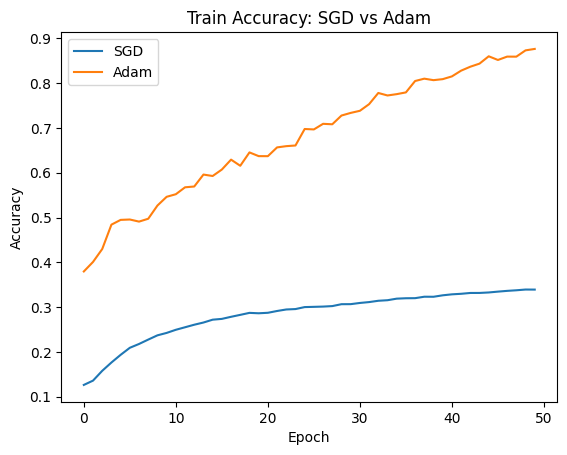

In [10]:
from torch.optim import SGD, Adam
import numpy as np

sgd_model = model.to('cuda')
adam_model = model.to('cuda')

sgd_accs = train(sgd_model, SGD(sgd_model.parameters(), lr=0.001))
adam_accs = train(adam_model, Adam(adam_model.parameters(), lr=0.001))

plot_acc([sgd_accs, adam_accs], ["SGD", "Adam"], "Train Accuracy: SGD vs Adam")

### 11. MLP 모델 정의 2
- Sigmoid를 사용한 기본 Model을 정의합니다.

In [11]:
class Model_Sigmoid(Model):
    def __init__(self, input_dim, n_dim):
        super().__init__(input_dim, n_dim)
        self.act = nn.Sigmoid()


model_sigmoid = Model_Sigmoid(3 * 32 * 32, 1024)

### 12. Plot 2 - LeakyReLU vs Sigmoid (Adam)


Epoch   0 | Loss: 76.51177825033665
Epoch   1 | Loss: 72.61214435100555
Epoch   2 | Loss: 70.45125459134579
Epoch   3 | Loss: 66.83101800084114
Epoch   4 | Loss: 64.31021389365196
Epoch   5 | Loss: 63.373185217380524
Epoch   6 | Loss: 58.37818856537342
Epoch   7 | Loss: 59.095650032162666
Epoch   8 | Loss: 56.77429239451885
Epoch   9 | Loss: 56.23578928411007
Epoch  10 | Loss: 52.86151297390461
Epoch  11 | Loss: 50.91740320622921
Epoch  12 | Loss: 53.21629962325096
Epoch  13 | Loss: 49.422660037875175
Epoch  14 | Loss: 50.71787005662918
Epoch  15 | Loss: 46.12648367881775
Epoch  16 | Loss: 49.11659999191761
Epoch  17 | Loss: 42.11304022371769
Epoch  18 | Loss: 45.43121959269047
Epoch  19 | Loss: 40.965702541172504
Epoch  20 | Loss: 42.267253793776035
Epoch  21 | Loss: 43.79279463738203
Epoch  22 | Loss: 43.44035071879625
Epoch  23 | Loss: 36.321511536836624
Epoch  24 | Loss: 38.49526962637901
Epoch  25 | Loss: 36.03624918311834
Epoch  26 | Loss: 36.394092939794064
Epoch  27 | Loss: 37.

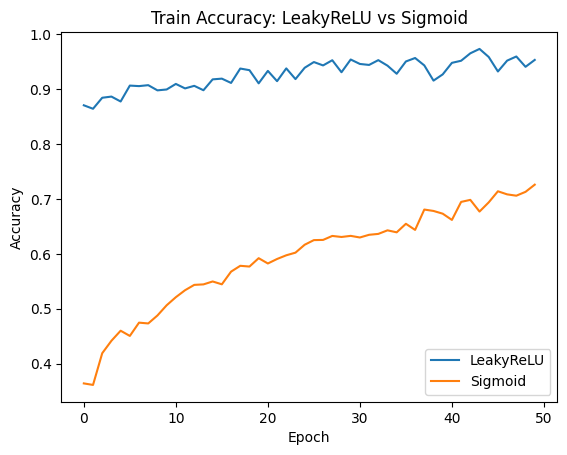

In [12]:
leaky_model = model.to('cuda')
sigmoid_model = model_sigmoid.to('cuda')

leaky_accs = train(leaky_model, Adam(leaky_model.parameters(), lr=0.001))
sigmoid_accs = train(sigmoid_model, Adam(sigmoid_model.parameters(), lr=0.001))

plot_acc([leaky_accs, sigmoid_accs], ["LeakyReLU", "Sigmoid"], "Train Accuracy: LeakyReLU vs Sigmoid")

### 13. MLP 모델 정의 3
- LeakyReLU + Dropout를 적용한 Model을 정의합니다.

In [13]:
class Model_Dropout(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)
        return x


model_dropout = Model_Dropout(3 * 32 * 32, 1024)

### 14. Plot 3 - Dropout 모델의 Train/Test Accuracy

Epoch   0 | Train: 0.57178, Test: 0.5235
Epoch   1 | Train: 0.55704, Test: 0.501
Epoch   2 | Train: 0.57406, Test: 0.5108
Epoch   3 | Train: 0.60272, Test: 0.536
Epoch   4 | Train: 0.5912, Test: 0.5157
Epoch   5 | Train: 0.6111, Test: 0.5316
Epoch   6 | Train: 0.61154, Test: 0.5235
Epoch   7 | Train: 0.62136, Test: 0.5209
Epoch   8 | Train: 0.6315, Test: 0.5353
Epoch   9 | Train: 0.6331, Test: 0.5312
Epoch  10 | Train: 0.6485, Test: 0.5409
Epoch  11 | Train: 0.6374, Test: 0.5267
Epoch  12 | Train: 0.65518, Test: 0.5338
Epoch  13 | Train: 0.66836, Test: 0.5394
Epoch  14 | Train: 0.66202, Test: 0.5301
Epoch  15 | Train: 0.67798, Test: 0.5424
Epoch  16 | Train: 0.6641, Test: 0.524
Epoch  17 | Train: 0.69038, Test: 0.547
Epoch  18 | Train: 0.69396, Test: 0.5377
Epoch  19 | Train: 0.69696, Test: 0.5359
Epoch  20 | Train: 0.70694, Test: 0.538
Epoch  21 | Train: 0.7017, Test: 0.534
Epoch  22 | Train: 0.7155, Test: 0.5401
Epoch  23 | Train: 0.71538, Test: 0.5377
Epoch  24 | Train: 0.73628, Tes

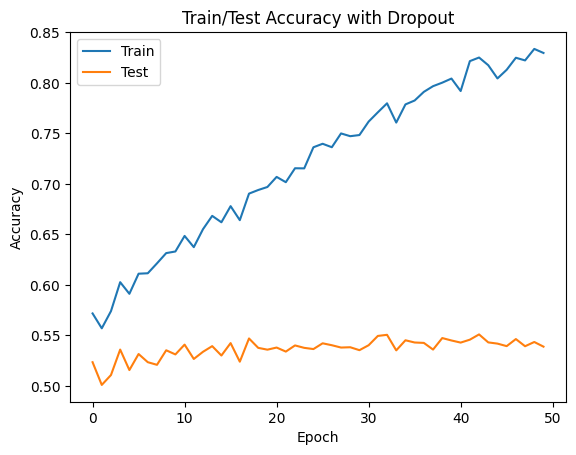

In [16]:
dropout_model = model_dropout.to('cuda')
optimizer = Adam(dropout_model.parameters(), lr=0.001)

n_epochs = 50
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    dropout_model.train()
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        pred = dropout_model(inputs)
        loss = nn.CrossEntropyLoss()(pred, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        dropout_model.eval()
        train_accs.append(accuracy(dropout_model, trainloader))
        test_accs.append(accuracy(dropout_model, testloader))
    print(f"Epoch {epoch:3d} | Train: {train_accs[-1]}, Test: {test_accs[-1]}")

plot_acc([train_accs, test_accs], ["Train", "Test"], "Train/Test Accuracy with Dropout")